### 0. Setup Workbook

In [1]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

### Read Inputs

In [4]:
all_sms_daco_output = load_query('all_sms_daco_output.sql')

2025-09-05 06:09:44,621 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-05 06:09:44,621 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-05 06:09:44,970 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-05 06:09:44,971 - utils.snowflake_connection - INFO - Executing query (pandas)


In [5]:
display(all_sms_daco_output[all_sms_daco_output['submarket_id'] == 0])

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965


### DxO Curve

Pittsburgh Cohort DxO Curve

In [6]:

# dxo_data = {
#     "spending": [10000, 49970, 99940, 149910, 199880, 249850],
#     "dxo_cpih": [15, 15, 15, 15, 15, 16]
# }

dxo_data = {
    "spending": [10000, 49970, 70000],
    "dxo_cpih": [15, 15, 15]
}

# $15
# $15
# $15
# $17
# $24

# $49,970
# $99,940
# $149,910
# $199,880
# $249,850

# Create the DataFrame
df_dxo = pd.DataFrame(dxo_data)

df_dxo

,spending,dxo_cpih
0,10000,15
1,49970,15
2,70000,15


Global DxO Curve (for SMs had peak pay in control)

In [7]:
global_dxo_data = {
    "spending": [1000000, 1363277, 2726554, 4089831, 5453108, 6816385],
    "dxo_cpih": [9, 9, 9, 9, 10, 15],
    "dxo_cpih_15": [15, 15, 15, 15, 15, 15]
}

# Create the DataFrame
df_global_dxo = pd.DataFrame(global_dxo_data)

df_global_dxo


,spending,dxo_cpih,dxo_cpih_15
0,1000000,9,15
1,1363277,9,15
2,2726554,9,15
3,4089831,9,15
4,5453108,10,15
5,6816385,15,15


### Pittsburgh Cohort SMs

##### Find SMs with similar size to Pittsburgh (25 SMs)

In [8]:
sm_bucket = load_query('top_sm.sql')

filtered_sm_bucket = sm_bucket[
    # (sm_bucket['bucket_uh'] >= 0.01) &
    (sm_bucket['bucket_delivs'] >= 150000) &
    (sm_bucket['bucket_delivs'] <= 500000) 
    # (sm_bucket['bucket_spend'] >= 50000) &
    # (sm_bucket['bucket_spend'] <= 100000)
]

# check if avaialble in the daco_spend_to_applicants_curve
available_sm = filtered_sm_bucket[filtered_sm_bucket['submarket_id'].isin(all_sms_daco_output['submarket_id'].unique())]
filtered_sm_bucket_list = available_sm['submarket_id'].unique().tolist()

available_sm

2025-09-05 06:10:16,727 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-05 06:10:16,727 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-05 06:10:17,131 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-05 06:10:17,132 - utils.snowflake_connection - INFO - Executing query (pandas)


,week,submarket_id,submarket_name,total_deliveries,uh_pct,undersupplied_hours,ideal_online_hours,uh_pct * 100,bucket_delivs,bucket_uh,total_budget,bucket_spend
2335,2025-08-25,303,Delaware,156663,0.015243,1095.663344,71880.698368,1.524280,160000.0,0.015,9844.0,10000.0
2338,2025-08-25,235,Birmingham,159224,0.062596,5316.851635,84939.801093,6.259553,160000.0,0.063,38156.0,40000.0
2340,2025-08-25,72,Queens,176601,0.009955,737.903501,74123.843051,0.995501,180000.0,0.010,29543.0,30000.0
2341,2025-08-25,167,New Orleans,180858,0.023517,2182.477236,92804.251906,2.351700,180000.0,0.024,45763.0,50000.0
2344,2025-08-25,334,Greenville,202549,0.024491,2317.460701,94624.535512,2.449112,200000.0,0.024,28085.0,30000.0
2345,2025-08-25,237,Buffalo,206496,0.029276,2703.223153,92334.836255,2.927631,210000.0,0.029,32411.0,30000.0
2347,2025-08-25,236,Memphis,216710,0.041758,4547.035985,108889.152623,4.175839,220000.0,0.042,76026.0,80000.0
2350,2025-08-25,305,Greensboro,235853,0.006592,670.736170,101743.711890,0.659241,240000.0,0.007,9262.0,10000.0
2351,2025-08-25,79,Louisville,238729,0.008940,945.867824,105800.380702,0.894012,240000.0,0.009,8668.0,10000.0
2355,2025-08-25,78,Richmond,266727,0.022022,2683.074071,121837.990167,2.202165,270000.0,0.022,49697.0,50000.0


In [9]:
df_sm81_cohort = all_sms_daco_output[all_sms_daco_output['submarket_id'].isin(filtered_sm_bucket_list)]
df_sm81_cohort = df_sm81_cohort.merge(available_sm[['submarket_id','total_deliveries']], on='submarket_id', how='left')

Weighted Avg by SM Size

In [10]:
def wavg(group, cols, weight_col="tot_delivs"):
    d = group[cols]
    w = group[weight_col]
    return (d.mul(w, axis=0).sum(axis=0)) / w.sum()

# Columns you want to aggregate
agg_cols = [
    'spending','applicants','new_dx','wad','hours'
    # ,'cpih','cpiwad','cpid',
    # 'cp_wad','cp_hour','hours_per_dx',
    # 'inc_spend','inc_apps','inc_new_dx','inc_wad','inc_hours',
    # 'inc_spend_final','inc_apps_final','inc_new_dx_final','inc_wad_final','inc_hours_final',
    # 'cpih_lifetime',   'inc_hours_lifetime'
]

df_sm81_cohort_weighted = (
    df_sm81_cohort
    .groupby("mcpd_scenario")
    .apply(lambda g: wavg(g, agg_cols, weight_col="total_deliveries"))
    .reset_index()
)

df_sm81_cohort_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,1000,6761.492607,148.027330,32.619527,230.019903,2540.001804
1,2000,17483.584935,193.762054,41.733787,294.638427,3278.044518
2,3000,31829.373883,229.000579,49.638979,350.464841,3909.212194
3,4000,43474.754107,252.268180,54.451708,384.732580,4292.652162
4,5000,54073.169555,267.932605,57.819544,408.693224,4564.537883
5,6000,63166.357721,278.106556,60.109352,424.764796,4739.365281
6,7000,70883.687764,286.305116,61.921804,437.442403,4876.504038
7,8000,77204.330626,294.787412,63.371014,447.568124,4987.766963
8,9000,82367.677587,299.552505,64.252440,453.739688,5056.860521
9,10000,85995.891963,302.909835,64.766119,457.418087,5100.361114


In [11]:
def calculate_cpih(df_sm81_cohort_weighted):
    df = df_sm81_cohort_weighted.copy()

    df['inc_spend'] = df['spending'].diff()
    df.loc[df.index[0], 'inc_spend'] = df['spending'].iloc[0]

    df['inc_applicants'] = df['applicants'].diff()
    df.loc[df.index[0], 'inc_applicants'] = df['applicants'].iloc[0]

    df['inc_new_dx'] = df['new_dx'].diff()
    df.loc[df.index[0], 'inc_new_dx'] = df['new_dx'].iloc[0]

    df['inc_wad'] = df['wad'].diff()
    df.loc[df.index[0], 'inc_wad'] = df['wad'].iloc[0]

    df['inc_hours'] = df['hours'].diff()
    df.loc[df.index[0], 'inc_hours'] = df['hours'].iloc[0]

    df['inc_hours_lifetime'] = df['inc_new_dx'] * 170

    df['cpih'] = df['inc_spend'] / (df['inc_hours'] * 1.2)
    ## why adjust for cpih
    # DACO applied a more aggressive churn rate of new dx than the actual churn rate, on avg 20% higher

    df['cpih_lifetime'] = df['inc_spend'] / df['inc_hours_lifetime']

    df['cpiwad'] = df['inc_spend'] / df['inc_wad']
    df['actual_mcpd'] = df['inc_spend'] / df['inc_new_dx']

    return df

df_sm81_cohort_weighted = calculate_cpih(df_sm81_cohort_weighted)

df_sm81_cohort_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd
0,1000,6761.492607,148.027330,32.619527,230.019903,2540.001804,6761.492607,148.027330,32.619527,230.019903,2540.001804,5545.319674,2.218336,1.219315,29.395250,207.283585
1,2000,17483.584935,193.762054,41.733787,294.638427,3278.044518,10722.092329,45.734724,9.114260,64.618523,738.042714,1549.424122,12.106450,6.920050,165.929083,1176.408492
2,3000,31829.373883,229.000579,49.638979,350.464841,3909.212194,14345.788948,35.238525,7.905192,55.826415,631.167676,1343.882627,18.940805,10.674882,256.971347,1814.730002
3,4000,43474.754107,252.268180,54.451708,384.732580,4292.652162,11645.380223,23.267601,4.812729,34.267738,383.439969,818.163881,25.309004,14.233555,339.835098,2419.704272
4,5000,54073.169555,267.932605,57.819544,408.693224,4564.537883,10598.415448,15.664424,3.367836,23.960644,271.885721,572.532118,32.484284,18.511478,442.325976,3146.951182
5,6000,63166.357721,278.106556,60.109352,424.764796,4739.365281,9093.188166,10.173951,2.289809,16.071572,174.827398,389.267472,43.343646,23.359743,565.793331,3971.156339
6,7000,70883.687764,286.305116,61.921804,437.442403,4876.504038,7717.330044,8.198560,1.812452,12.677607,137.138757,308.116852,46.894900,25.046764,608.737118,4257.949865
7,8000,77204.330626,294.787412,63.371014,447.568124,4987.766963,6320.642862,8.482296,1.449210,10.125721,111.262925,246.365625,47.340139,25.655539,624.216564,4361.441607
8,9000,82367.677587,299.552505,64.252440,453.739688,5056.860521,5163.346960,4.765093,0.881426,6.171564,69.093557,149.842486,62.274824,34.458498,836.635075,5857.944622
9,10000,85995.891963,302.909835,64.766119,457.418087,5100.361114,3628.214376,3.357330,0.513678,3.678398,43.500593,87.325319,69.505074,41.548252,986.357141,7063.202879


##### Train Spending <> mCPD <> CPIH curve for DACO

Define training formulas

In [12]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises ordinary-least-squares R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and plot with a unified styling.
       Returns (summary_df, pred_df)
    """
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit

    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})
    return summary, pred_df


def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise the results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            formula = summ.loc[0, "formula"]
            r2 = summ.loc[0, "r2"]
            results.append((kind, formula, r2))
            fitted_dfs[kind] = pred_df
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])

    print("\nFitted Models:")
    for kind, formula, r2 in results:
        if formula is not None:
            print(f"{kind:<10}: {formula}   (R²={r2:.4f})")
        else:
            print(f"{kind:<10}: <failed>")

    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df


##### Spending <> mCPD

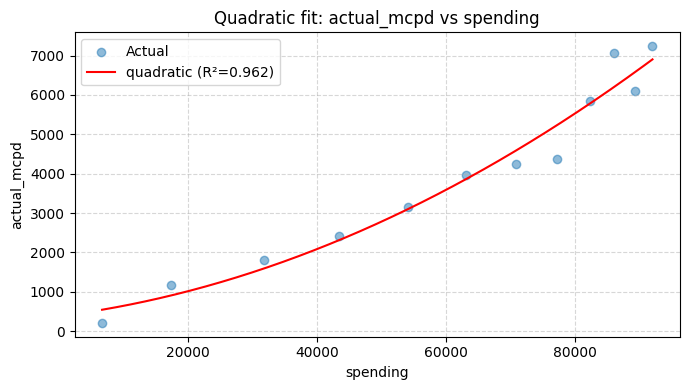


Fitted Models:
quadratic : actual_mcpd = 0.0000005460·spending² + 0.021·spending + 375.7367823324   (R²=0.9617)

Best Model → quadratic  (R²=0.9617)


In [13]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="spending",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [14]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd

,spending,_x2,actual_mcpd
0,6761.492607,4.571778e+07,541.179982
1,6932.239910,4.805595e+07,546.004148
2,7102.987213,5.045243e+07,550.860150
3,7273.734517,5.290721e+07,555.747987
4,7444.481820,5.542031e+07,560.667659
...,...,...,...
495,91281.407746,8.332295e+09,6821.475453
496,91452.155050,8.363497e+09,6842.058053
497,91622.902353,8.394756e+09,6862.672489
498,91793.649656,8.426074e+09,6883.318759


In [15]:
# Quadratic coefficients from your fitted model
a = 0.000001     # coefficient for spending²
b = 0.020        # coefficient for spending
c = 383.472536   # intercept

# Function to solve quadratic equation a*x^2 + b*x + c = y_target
def solve_for_spending(y_target):
    A = a
    B = b
    C = c - y_target
    
    D = B**2 - 4*A*C  # discriminant
    if D < 0:
        return np.nan  # no real solution
    sqrt_D = np.sqrt(D)
    x1 = (-B + sqrt_D) / (2*A)
    x2 = (-B - sqrt_D) / (2*A)
    # pick the positive root (since spending must be > 0)
    roots = [val for val in (x1, x2) if val > 0]
    return max(roots) if roots else np.nan

# Target actual_mcpd values
targets = np.arange(1000, 12001, 1000)  # from 1000 to 12000 step 1000


# Calculate spending for each target
results = [(t, solve_for_spending(t)) for t in targets]

# Save in DataFrame
df_mcpd_spending = pd.DataFrame(results, columns=["mcpd_target", "pred_spending"])

df_mcpd_spending


,mcpd_target,pred_spending
0,1000,16768.030634
1,2000,31430.996416
2,3000,42120.317190
3,4000,50963.328846
4,5000,58676.979141
5,6000,65607.720928
6,7000,71954.423090
7,8000,77843.767360
8,9000,83362.345001
9,10000,88572.447793


##### mCPD <> mCPIH

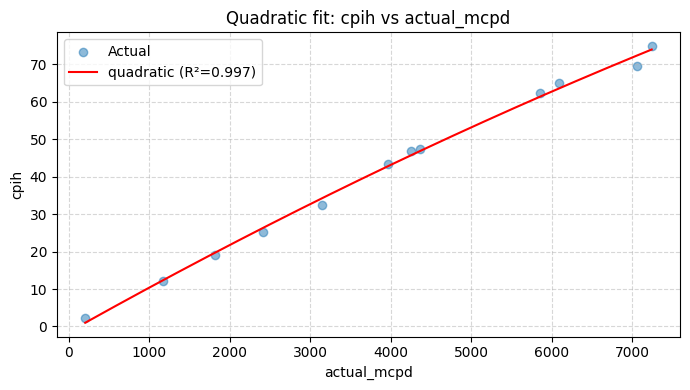


Fitted Models:
quadratic : cpih = -0.0000002280·actual_mcpd² + 0.012·actual_mcpd + -1.4926882865   (R²=0.9969)

Best Model → quadratic  (R²=0.9969)


In [16]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [17]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih

,actual_mcpd,_x2,cpih
0,207.283585,4.296648e+04,0.997950
1,221.377125,4.900783e+04,1.166581
2,235.470665,5.544643e+04,1.335122
3,249.564205,6.228229e+04,1.503572
4,263.657745,6.951541e+04,1.671931
...,...,...,...
495,7183.585851,5.160391e+07,73.397103
496,7197.679391,5.180659e+07,73.520903
497,7211.772931,5.200967e+07,73.644613
498,7225.866471,5.221315e+07,73.768232


##### mCPD <> mCPIH Lifetime

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


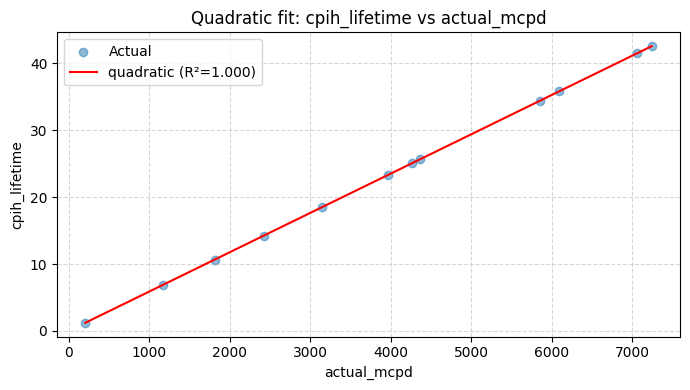


Fitted Models:
quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + -0.0000000000   (R²=1.0000)

Best Model → quadratic  (R²=1.0000)


In [18]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [19]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime.head()

,actual_mcpd,_x2,cpih_lifetime
0,207.283585,42966.484692,1.219315
1,221.377125,49007.831530,1.302218
2,235.470665,55446.434103,1.385122
3,249.564205,62282.292412,1.468025
4,263.657745,69515.406457,1.550928


In [20]:
# Step 1: spending range (10k to 150k in steps of 10k)
spending = np.arange(10000, 70001, 10000)

# Step 2: MCPD formula (replace coefficients with yours)
def mcpd_formula(s):
    """
    Fitted Models:
    quadratic : actual_mcpd = 0.000001·spending² + 0.020·spending + 383.472766   (R²=0.9623)
    """
    return (0.000001*s**2 + 0.020*s + 383.472766)

# Step 3: CPIH formula in terms of MCPD
def cpih_formula(m):
    """
    Fitted Models:
    quadratic : cpih = -0.0000001·actual_mcpd² + 0.012·actual_mcpd + -1.542277   (R²=0.9965)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.0000001*m**2 + 0.012*m + -1.542277)

def cpih_lifetime_formula(m):
    """
    Fitted Models:
    quadratic : cpih_lifetime = -0.000000·actual_mcpd² + 0.006·actual_mcpd + -0.000000   (R²=1.0000)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.0000001*m**2 + 0.006*m + -0.000000 )


# Step 4: Compute values
mcpd = mcpd_formula(spending)
cpih = cpih_formula(mcpd)
cpih_lifetime = cpih_lifetime_formula(mcpd)

# Step 5: Build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime
})

df_new


,spending,mcpd,cpih,cpih_lifetime
0,10000,683.472766,6.612683,4.054123
1,20000,1183.472766,12.519335,6.960776
2,30000,1883.472766,20.704649,10.946090
3,40000,2783.472766,31.084624,15.926065
4,50000,3883.472766,43.551260,21.792701
5,60000,5183.472766,57.972557,28.413998
6,70000,6683.472766,74.192515,35.633956


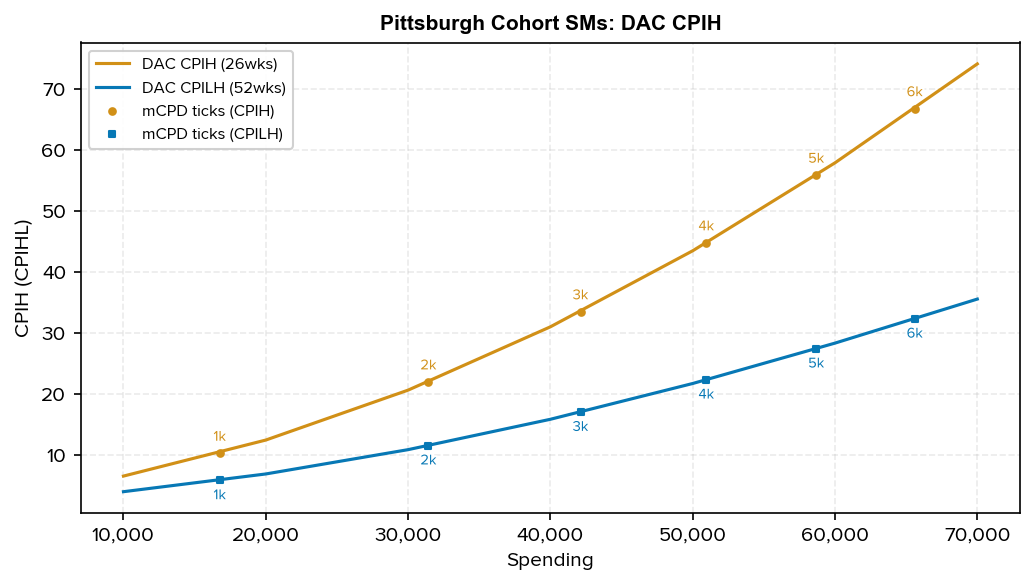

In [25]:
mcpd_levels = np.arange(1000, 6001, 1000)  # 1k..9k (adjust as needed)

a, b, c = 1e-6, 0.020, 383.472766

def spend_from_mcpd(m):
    D = b**2 - 4*a*(c - m)
    return (-b + np.sqrt(D)) / (2*a)

# Exact spending values that produce those MCPD levels
spending_marks = spend_from_mcpd(mcpd_levels)
cpih_marks = cpih_formula(mcpd_levels)
cpih_lifetime_marks = cpih_lifetime_formula(mcpd_levels)

plt.rcParams.update({
    "figure.dpi": 150,                   # crisp display at normal size
    "savefig.dpi": 300,                  # high-res export
    "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,              
})

colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#403f3e"}

fig, ax = plt.subplots(figsize=(7, 4))   # regular size

line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC CPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC CPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
# line3, = ax.plot(df_dxo["spending"], df_dxo["dxo_cpih"], label="DxO CPIH ($15)", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)

# 5) Tick markers (smaller, same color as lines)
ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

# 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
halo = [pe.withStroke(linewidth=2, foreground="white")]
for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.set_xlabel("Spending")
ax.set_ylabel("CPIH (CPIHL)")
# ax.set_title("Pittsburgh Cohort SMs: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.set_title("Pittsburgh Cohort SMs: DAC CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
# ax.legend(handles=[line1, line2, line3, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
fig.tight_layout()
plt.show()

## Global

#### SM0 View

##### Prepare

In [26]:
df_sm0 = all_sms_daco_output[all_sms_daco_output['submarket_id'] == 0]
df_sm0 

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965


In [27]:
df_sm0_calc = calculate_cpih(df_sm0)
df_sm0_calc

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869,466964.214273,8169.743731,1703.735784,11969.157528,136629.136869,289635.083227,2.848125,1.612250,39.013958,274.082530
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040,861740.667110,3639.146407,702.121644,4951.159213,53629.514172,119360.679489,13.390336,7.219636,174.048264,1227.338132
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212,925980.824683,2147.680946,417.975322,2955.918777,32010.677171,71055.804786,24.106041,13.031741,313.263285,2215.395923
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367,781777.335867,1341.498947,249.634958,1779.327771,18548.196155,42437.942788,35.123691,18.421660,439.366680,3131.682131
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641,760979.724742,1107.888791,201.896618,1434.702208,15239.446274,34322.425104,41.612389,22.171502,530.409531,3769.155379
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642,628007.121212,706.777783,132.675700,939.705942,10015.349001,22554.868981,52.253723,27.843528,668.301745,4733.399724
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991,540308.945270,517.720708,104.684265,745.166684,7516.371349,17796.325069,59.903567,30.360703,725.084678,5161.319561
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471,453125.915792,476.498516,89.800793,640.821763,6513.551480,15266.134884,57.972203,29.681771,707.101322,5045.901027
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830,388500.293233,421.043514,82.032989,588.738559,5685.764359,13945.608058,56.940496,27.858254,659.885933,4735.903201
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965,311227.886167,386.321999,69.068883,499.857962,4332.191136,11741.710076,59.867297,26.506180,622.632647,4506.050678


In [69]:
df_sm0_calc['avg_cpih'] = df_sm0_calc['spending'] / df_sm0_calc['hours']
df_sm0_calc['avg_cpwad'] = df_sm0_calc['spending'] / df_sm0_calc['wad']
df_sm0_calc['hours_per_dx'] = df_sm0_calc['hours'] / df_sm0_calc['wad']
df_sm0_calc_output = df_sm0_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]
df_sm0_calc_output

,actual_mcpd,spending,applicants,new_dx,hours,wad,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx
0,274.082530,4.669642e+05,8169.743731,1703.735784,136629.136869,11969.157528,2.848125,1.612250,3.417750,39.013958,11.415101
1,1227.338132,1.328705e+06,11808.890138,2405.857428,190258.651040,16920.316741,13.390336,7.219636,6.983677,78.527187,11.244391
2,2215.395923,2.254686e+06,13956.571084,2823.832750,222269.328212,19876.235518,24.106041,13.031741,10.143935,113.436254,11.182667
3,3131.682131,3.036463e+06,15298.070031,3073.467708,240817.524367,21655.563289,35.123691,18.421660,12.608979,140.216304,11.120354
4,3769.155379,3.797443e+06,16405.958823,3275.364326,256056.970641,23090.265497,41.612389,22.171502,14.830460,164.460767,11.089390
5,4733.399724,4.425450e+06,17112.736606,3408.040026,266072.319642,24029.971439,52.253723,27.843528,16.632508,184.163760,11.072519
6,5161.319561,4.965759e+06,17630.457314,3512.724291,273588.690991,24775.138123,59.903567,30.360703,18.150454,200.433144,11.042872
7,5045.901027,5.418885e+06,18106.955830,3602.525084,280102.242471,25415.959887,57.972203,29.681771,19.346096,213.207952,11.020723
8,4735.903201,5.807385e+06,18527.999344,3684.558073,285788.006830,26004.698445,56.940496,27.858254,20.320604,223.320607,10.989860
9,4506.050678,6.118613e+06,18914.321342,3753.626956,290120.197965,26504.556407,59.867297,26.506180,21.089924,230.851361,10.946050


##### Spending <> mCPD

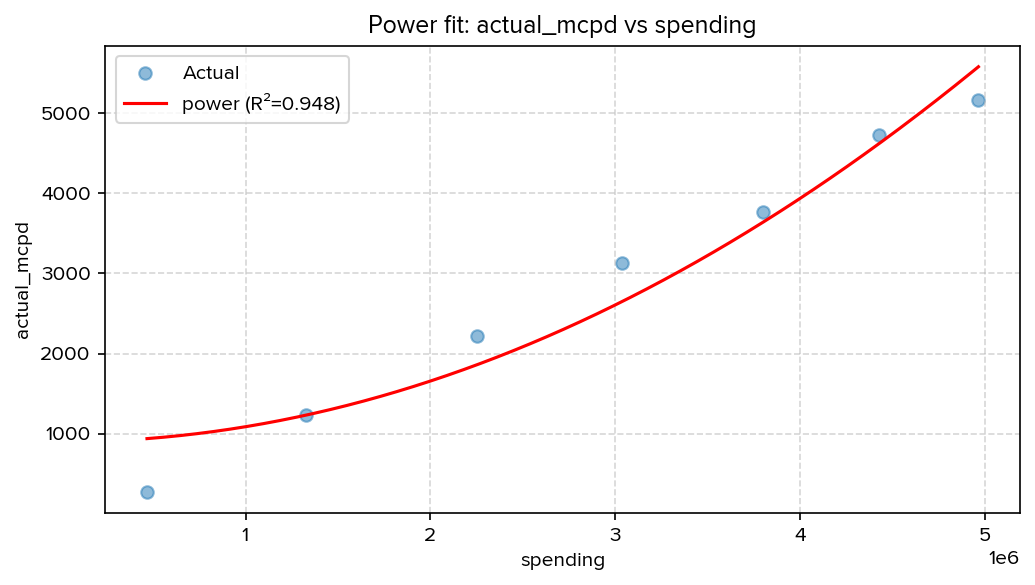


Fitted Models:
power     : actual_mcpd = 0.0000000002·(spending^2.0) + 896.8507731041   (R²=0.9482)

Best Model → power  (R²=0.9482)


In [28]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm0_calc[df_sm0_calc['spending'] < 5000000],
    x_col="spending",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)


In [29]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd.head()

,spending,_pow_x,actual_mcpd
0,466964.214273,2.180556e+11,938.262993
1,475979.834751,2.265568e+11,939.877511
2,484995.455230,2.352206e+11,941.522902
3,494011.075709,2.440469e+11,943.199167
4,503026.696188,2.530359e+11,944.906305


##### mCPD <> CPIH

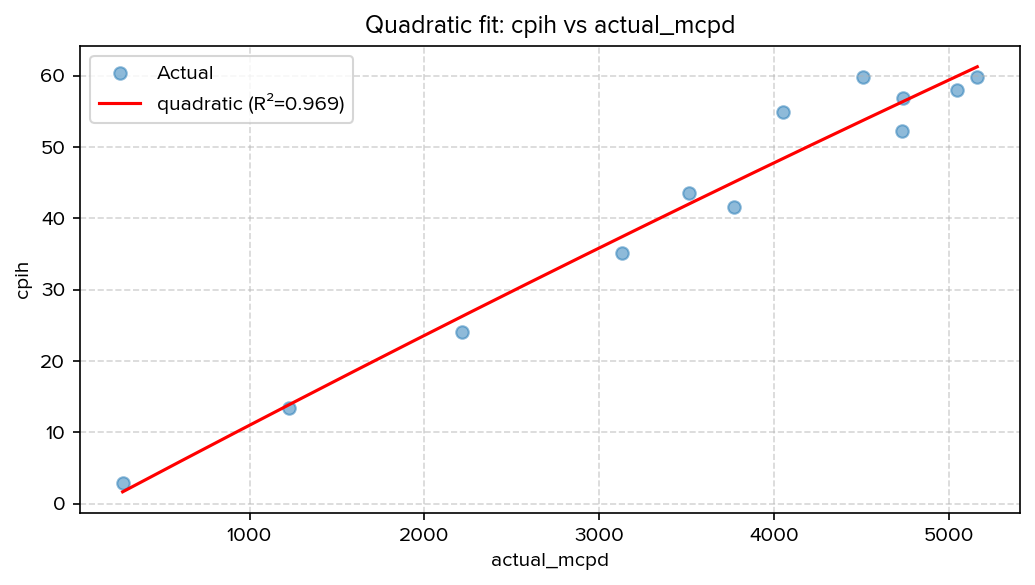


Fitted Models:
quadratic : cpih = -0.0000001625·actual_mcpd² + 0.013·actual_mcpd + -1.9223878395   (R²=0.9687)

Best Model → quadratic  (R²=0.9687)


In [30]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm0_calc,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [31]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih

,actual_mcpd,_x2,cpih
0,274.082530,7.512123e+04,1.651087
1,283.876592,8.058592e+04,1.778329
2,293.670655,8.624245e+04,1.905541
3,303.464717,9.209083e+04,2.032721
4,313.258779,9.813106e+04,2.159871
...,...,...,...
495,5122.143313,2.623635e+07,60.825242
496,5131.937375,2.633678e+07,60.937055
497,5141.731437,2.643740e+07,61.048838
498,5151.525499,2.653821e+07,61.160589


##### mCPD <> mCPILH

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


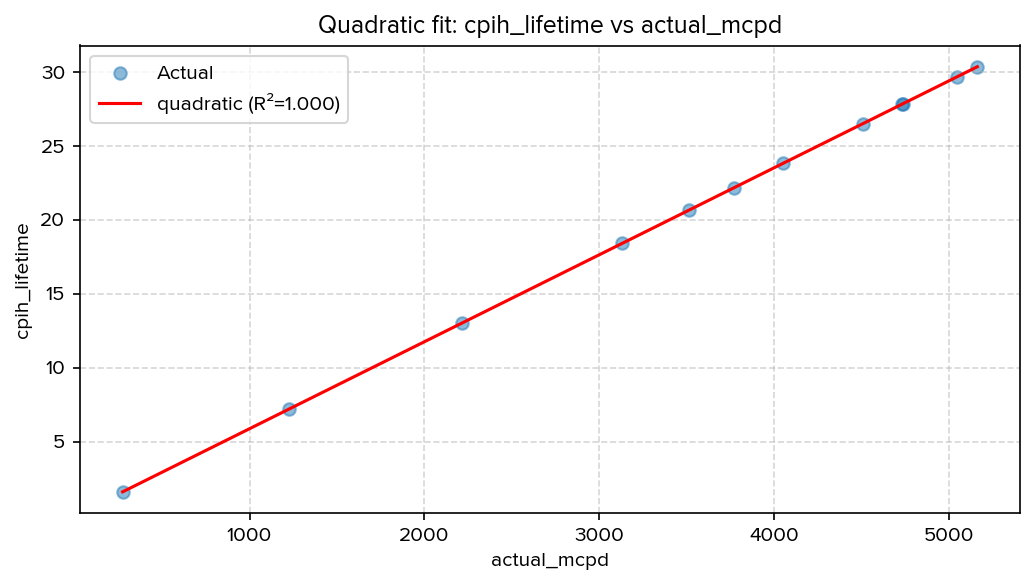


Fitted Models:
quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + -0.0000000000   (R²=1.0000)

Best Model → quadratic  (R²=1.0000)


In [56]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_sm0_calc,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [ ]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime

,actual_mcpd,_x2,cpih_lifetime
0,274.082530,7.512123e+04,1.612250
1,283.876592,8.058592e+04,1.669862
2,293.670655,8.624245e+04,1.727474
3,303.464717,9.209083e+04,1.785087
4,313.258779,9.813106e+04,1.842699
...,...,...,...
495,5122.143313,2.623635e+07,30.130255
496,5131.937375,2.633678e+07,30.187867
497,5141.731437,2.643740e+07,30.245479
498,5151.525499,2.653821e+07,30.303091


##### Plot the chart

In [33]:
# Step 1: spending range (10k to 150k in steps of 10k)
spending = np.arange(1000000, 7000001, 1000000)

# Step 2: MCPD formula (replace coefficients with yours)
def mcpd_formula(s):
    """
    Fitted Models:
    quadratic : actual_mcpd = 0.000000·spending² + 0.001·spending + -221.640309   (R²=0.9978)
    Fitted Models:
    power     : actual_mcpd = 0.0000000002·(spending^2.0) + 896.8507731041   (R²=0.9482)
    """
    # return (0.00000000001*s**2 + 0.001*s + -221.640309)
    return (0.0000000002*s**2 + 896.8507731041)

# Step 3: CPIH formula in terms of MCPD
def cpih_formula(m):
    """
    Fitted Models:
    quadratic : cpih = -0.000000·actual_mcpd² + 0.013·actual_mcpd + -1.922388   (R²=0.9687)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.00000000001*m**2 + 0.013*m +  -1.922388)

def cpih_lifetime_formula(m):
    """
    Fitted Models:
    quadratic : cpih_lifetime = -0.000000·actual_mcpd² + 0.006·actual_mcpd + -0.000000   (R²=1.0000)
    Best Model → quadratic  (R²=0.9965)
    """
    return (-0.00000000001*m**2 + 0.006*m + -0.000000 )


# Step 4: Compute values
mcpd = mcpd_formula(spending)
cpih = cpih_formula(mcpd)
cpih_lifetime = cpih_lifetime_formula(mcpd)

# Step 5: Build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime
})

df_new


,spending,mcpd,cpih,cpih_lifetime
0,1000000,1096.850773,12.336660,6.581093
1,2000000,1696.850773,20.136643,10.181076
2,3000000,2696.850773,33.136599,16.181032
3,4000000,4096.850773,51.336504,24.580937
4,5000000,5896.850773,74.736324,35.380757
5,6000000,8096.850773,103.336016,48.580449
6,7000000,10696.850773,137.135528,64.179960


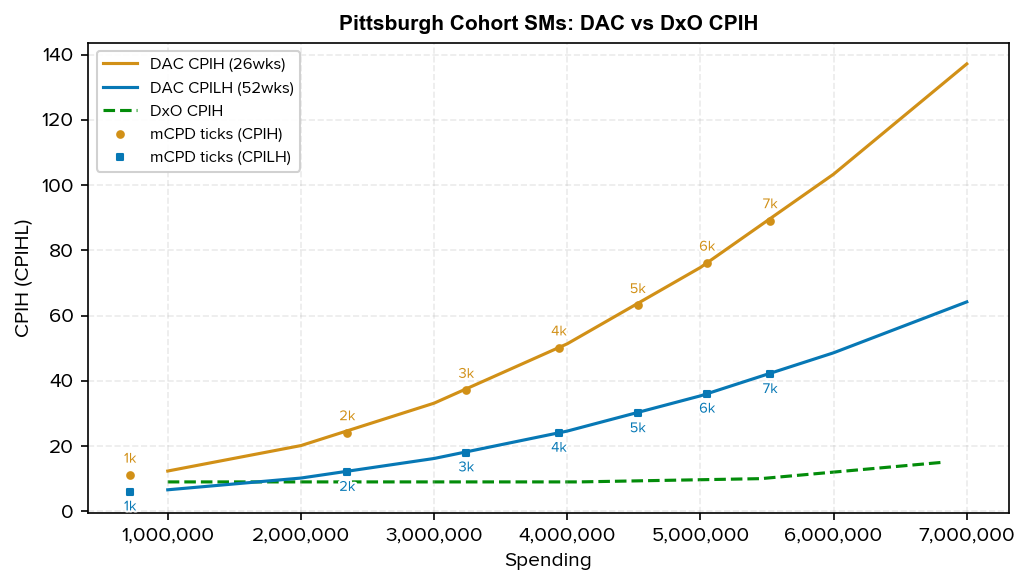

In [34]:
mcpd_levels = np.arange(1000, 7001, 1000)  # 1k..9k (adjust as needed)

# a, b, c = 0.00000000001, 0.001, -221.640309

# def spend_from_mcpd(m):
#     D = b**2 - 4*a*(c - m)
#     return (-b + np.sqrt(D)) / (2*a)

#    return (0.0000000002*s**2 + 896.8507731041)

a = 0.0000000002
c = 896.8507731041 


def spend_from_mcpd(m):
    m = np.asarray(m)  # ensure NumPy array
    # if np.any(m <= c):
        # raise ValueError(f"Some MCPD values are <= {c}, spending would be undefined.")
    return np.sqrt((m - c) / a)


# Exact spending values that produce those MCPD levels
spending_marks = spend_from_mcpd(mcpd_levels)
cpih_marks = cpih_formula(mcpd_levels)
cpih_lifetime_marks = cpih_lifetime_formula(mcpd_levels)

plt.rcParams.update({
    "figure.dpi": 150,                   # crisp display at normal size
    "savefig.dpi": 300,                  # high-res export
    "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,              
})

colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#038c0a"}

fig, ax = plt.subplots(figsize=(7, 4))   # regular size

line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC CPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC CPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)

# 5) Tick markers (smaller, same color as lines)
ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

# 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
halo = [pe.withStroke(linewidth=2, foreground="white")]
for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.set_xlabel("Spending")
ax.set_ylabel("CPIH (CPIHL)")
ax.set_title("Pittsburgh Cohort SMs: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
ax.legend(handles=[line1, line2, line3, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

fig.tight_layout()
plt.show()

### Top SMs

#### Prepare data

In [35]:
len(all_sms_daco_output['submarket_id'].unique())

sm_bucket = load_query('top_sm.sql')

2025-09-05 06:14:23,017 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-05 06:14:23,018 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-05 06:14:23,400 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-05 06:14:23,400 - utils.snowflake_connection - INFO - Executing query (pandas)


In [36]:

# df_top_sms = sm_bucket.merge(all_sms_daco_output[all_sms_daco_output['mcpd_scenario'] == 1000], on='submarket_id', how='left').sort_values(by='total_deliveries', ascending=False)


In [38]:
df_global = all_sms_daco_output[all_sms_daco_output['submarket_id']!= 0].copy()
df_global = df_global.merge(sm_bucket[['submarket_id','total_deliveries']], on='submarket_id', how='left').fillna(0)

df_calc = df_global.groupby('submarket_id').apply(lambda x: calculate_cpih(x))
df_calc = df_calc.reset_index(drop=True)

exclude_sms = df_calc[df_calc['inc_applicants'] < 0]['submarket_id'].unique().tolist() + df_calc[df_calc['inc_new_dx'] < 0]['submarket_id'].unique().tolist() + df_calc[df_calc['cpih'] > 120]['submarket_id'].unique().tolist()    
df_calc = df_calc[~df_calc['submarket_id'].isin(exclude_sms)]


def wavg(group, cols, weight_col="tot_delivs"):
    d = group[cols]
    w = group[weight_col]
    return (d.mul(w, axis=0).sum(axis=0)) / w.sum()

# Columns you want to aggregate
agg_cols = [
    'spending','applicants','new_dx','wad','hours','total_deliveries'
]

df_global_weighted = (
    df_calc
    .groupby("mcpd_scenario")
    .apply(lambda g: wavg(g, agg_cols, weight_col="spending"))
    # .apply(lambda g: wavg(g, agg_cols, weight_col="total_deliveries"))
    .reset_index()
)

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries
0,1000,8270.070428,168.000439,36.623803,256.053079,2894.796644,412888.012707
1,2000,21229.800938,215.997979,46.056319,322.850417,3665.961009,392094.484365
2,3000,38830.082665,258.143954,55.149002,386.305515,4385.521552,395505.277376
3,4000,54894.862591,288.858461,61.256108,429.256098,4882.510737,392600.003530
4,5000,70764.251826,313.492863,66.587442,466.052682,5300.683176,393916.603166
5,6000,84045.758834,329.912914,70.023202,489.912546,5575.824832,395796.297105
6,7000,95608.525510,343.138628,72.896772,509.687564,5799.725325,396282.127822
7,8000,104197.320179,352.285031,74.701819,522.299316,5941.866638,394928.173732
8,9000,111133.870254,358.864803,75.881485,530.554354,6038.183978,393774.672496
9,10000,117223.060601,363.789789,76.677789,536.267599,6106.761219,393699.607755


In [39]:
df_global_weighted = df_global_weighted.merge(df_sm0_calc[['mcpd_scenario','spending','applicants']], on='mcpd_scenario', how='left', suffixes=('', '_sm0'))


In [552]:
# df_calc.sort_values(by='cpih', ascending=False)

In [553]:
# import matplotlib.pyplot as plt

# # Assume df_calc has columns: ["mcpd", "cpih", "submarket_id"]

# # Get unique submarket IDs
# submarkets = df_calc["submarket_id"].unique()

# # Group them in chunks of 10
# chunks = [submarkets[i:i+10] for i in range(0, len(submarkets), 10)]

# # Loop through chunks and plot
# for idx, group in enumerate(chunks, 1):
#     plt.figure(figsize=(8, 5))
    
#     for sm in group:
#         subset = df_calc[df_calc["submarket_id"] == sm]
#         plt.plot(subset["mcpd_scenario"], subset["cpih"], label=f"SM {sm}")
    
#     plt.xlabel("MCPD")
#     plt.ylabel("CPIH")
#     plt.title(f"CPIH vs MCPD (Submarkets {idx*10-9}–{idx*10})")
#     plt.legend(fontsize=8, ncol=2, framealpha=0.7)  # smaller legend
#     plt.grid(alpha=0.3)
#     plt.tight_layout()
#     plt.show()


In [ ]:
df_global_weighted = calculate_cpih(df_global_weighted)
df_global_weighted['spending_ratio'] = df_global_weighted['spending'] / df_global_weighted['spending_sm0']
df_global_weighted['spending_scaled'] = df_global_weighted['applicants_sm0'] / df_global_weighted['applicants'] * df_global_weighted['spending']

df_global_weighted

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries,spending_sm0,applicants_sm0,inc_spend,...,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_ratio,spending_scaled
0,1000,8270.070428,168.000439,36.623803,256.053079,2894.796644,412888.012707,4.669642e+05,8169.743731,8270.070428,...,36.623803,256.053079,2894.796644,6226.046517,2.380729,1.328302,32.298266,225.811351,0.017710,4.021677e+05
1,2000,21229.800938,215.997979,46.056319,322.850417,3665.961009,392094.484365,1.328705e+06,11808.890138,12959.730510,...,9.432516,66.797338,771.164365,1603.527763,14.004505,8.082012,194.015672,1373.942028,0.015978,1.160661e+06
2,3000,38830.082665,258.143954,55.149002,386.305515,4385.521552,395505.277376,2.254686e+06,13956.571084,17600.281726,...,9.092682,63.455098,719.560543,1545.756022,20.383137,11.386196,277.365923,1935.653397,0.017222,2.099351e+06
3,4000,54894.862591,288.858461,61.256108,429.256098,4882.510737,392600.003530,3.036463e+06,15298.070031,16064.779926,...,6.107106,42.950583,496.989184,1038.208036,26.936837,15.473565,374.029376,2630.506115,0.018079,2.907256e+06
4,5000,70764.251826,313.492863,66.587442,466.052682,5300.683176,393916.603166,3.797443e+06,16405.958823,15869.389236,...,5.331334,36.796584,418.172439,906.326764,31.624492,17.509567,431.273432,2976.626396,0.018635,3.703291e+06
5,6000,84045.758834,329.912914,70.023202,489.912546,5575.824832,395796.297105,4.425450e+06,17112.736606,13281.507007,...,3.435760,23.859864,275.141656,584.079267,40.226270,22.739220,556.646385,3865.667417,0.018991,4.359493e+06
6,7000,95608.525510,343.138628,72.896772,509.687564,5799.725325,396282.127822,4.965759e+06,17630.457314,11562.766676,...,2.873570,19.775017,223.900494,488.506860,43.035362,23.669610,584.715888,4023.833635,0.019254,4.912365e+06
7,8000,104197.320179,352.285031,74.701819,522.299316,5941.866638,394928.173732,5.418885e+06,18106.955830,8588.794669,...,1.805048,12.611752,142.141313,306.858081,50.353615,27.989469,681.015185,4758.209687,0.019229,5.355596e+06
8,9000,111133.870254,358.864803,75.881485,530.554354,6038.183978,393774.672496,5.807385e+06,18527.999344,6936.550075,...,1.179665,8.255039,96.317340,200.543082,60.014722,34.588828,840.280728,5880.100679,0.019137,5.737783e+06
9,10000,117223.060601,363.789789,76.677789,536.267599,6106.761219,393699.607755,6.118613e+06,18914.321342,6089.190346,...,0.796305,5.713244,68.577241,135.371777,73.994305,44.981240,1065.802550,7646.810772,0.019158,6.094714e+06


In [75]:
df_global_weighted['avg_cpa'] = df_global_weighted['spending'] / df_global_weighted['applicants']
df_global_weighted['avg_cpih'] = df_global_weighted['spending'] / df_global_weighted['hours']
df_global_weighted['avg_cpwad'] = df_global_weighted['spending'] / df_global_weighted['wad']
df_global_weighted['hours_per_dx'] = df_global_weighted['hours'] / df_global_weighted['wad']
df_global_weighted['avg_cpd'] = df_global_weighted['spending'] / df_global_weighted['new_dx']

df_global_weighted_output = df_global_weighted[['mcpd_scenario', 'actual_mcpd', 'spending_scaled', 'cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx', 'avg_cpa', 'avg_cpd']]
df_global_weighted_output['applicants'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpa']
df_global_weighted_output['new_dx'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpd']
df_global_weighted_output['wad'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpwad']
df_global_weighted_output['hours'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpih']
df_global_weighted_output[['mcpd_scenario','actual_mcpd', 'spending_scaled','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx', 'avg_cpa', 'avg_cpd']]


# df_sm0_calc_output = df_sm0_calc[['actual_mcpd', 'spending','applicants', 'new_dx', 'hours', 'wad','cpih','cpih_lifetime', 'avg_cpih', 'avg_cpwad', 'hours_per_dx']]


/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_77042/3799618141.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['applicants'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpa']
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_77042/3799618141.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_global_weighted_output['new_dx'] = df_global_weighted_output['spending_scaled'] / df_global_weighted_output['avg_cpd']
/var/fol

,mcpd_scenario,actual_mcpd,spending_scaled,applicants,new_dx,hours,wad,cpih,cpih_lifetime,avg_cpih,avg_cpwad,hours_per_dx,avg_cpa,avg_cpd
0,1000,225.811351,4.021677e+05,8169.743731,1780.989900,140771.934025,12451.681938,2.380729,1.328302,2.856874,32.298266,11.305455,49.226481,225.811351
1,2000,1373.942028,1.160661e+06,11808.890138,2517.958816,200422.851458,17650.651773,14.004505,8.082012,5.791060,65.757390,11.354983,98.287035,460.953052
2,3000,1935.653397,2.099351e+06,13956.571084,2981.634666,237103.531694,20885.634867,20.383137,11.386196,8.854154,100.516511,11.352469,150.420267,704.094026
3,4000,2630.506115,2.907256e+06,15298.070031,3244.150185,258579.897736,22733.590140,26.936837,15.473565,11.243163,127.883711,11.374354,190.040695,896.153290
4,5000,2976.626396,3.703291e+06,16405.958823,3484.707170,277399.584270,24389.841100,31.624492,17.509567,13.350025,151.837452,11.373571,225.728430,1062.726693
5,6000,3865.667417,4.359493e+06,17112.736606,3632.136128,289220.632374,25411.992085,40.226270,22.739220,15.073242,171.552575,11.381266,254.751346,1200.255861
6,7000,4023.833635,4.912365e+06,17630.457314,3745.434999,297989.796253,26187.739021,43.035362,23.669610,16.485009,187.582614,11.378981,278.629445,1311.560484
7,8000,4758.209687,5.355596e+06,18106.955830,3839.568606,305403.600188,26845.451284,50.353615,27.989469,17.536126,199.497332,11.376363,295.775611,1394.843137
8,9000,5880.100679,5.737783e+06,18527.999344,3917.720790,311748.234935,27392.239811,60.014722,34.588828,18.405181,209.467455,11.380896,309.681723,1464.571638
9,10000,7646.810772,6.094714e+06,18914.321342,3986.665894,317505.459171,27881.864720,73.994305,44.981240,19.195619,218.590608,11.387526,322.227462,1528.774653


In [61]:


# df_global_weighted.style.set_table_attributes("style='display:inline'")
pd.set_option("display.max_columns", None)
display(df_global_weighted)

,mcpd_scenario,spending,applicants,new_dx,wad,hours,total_deliveries,spending_sm0,applicants_sm0,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_ratio,spending_scaled
0,1000,8270.070428,168.000439,36.623803,256.053079,2894.796644,412888.012707,4.669642e+05,8169.743731,8270.070428,168.000439,36.623803,256.053079,2894.796644,6226.046517,2.380729,1.328302,32.298266,225.811351,0.017710,4.021677e+05
1,2000,21229.800938,215.997979,46.056319,322.850417,3665.961009,392094.484365,1.328705e+06,11808.890138,12959.730510,47.997540,9.432516,66.797338,771.164365,1603.527763,14.004505,8.082012,194.015672,1373.942028,0.015978,1.160661e+06
2,3000,38830.082665,258.143954,55.149002,386.305515,4385.521552,395505.277376,2.254686e+06,13956.571084,17600.281726,42.145976,9.092682,63.455098,719.560543,1545.756022,20.383137,11.386196,277.365923,1935.653397,0.017222,2.099351e+06
3,4000,54894.862591,288.858461,61.256108,429.256098,4882.510737,392600.003530,3.036463e+06,15298.070031,16064.779926,30.714506,6.107106,42.950583,496.989184,1038.208036,26.936837,15.473565,374.029376,2630.506115,0.018079,2.907256e+06
4,5000,70764.251826,313.492863,66.587442,466.052682,5300.683176,393916.603166,3.797443e+06,16405.958823,15869.389236,24.634403,5.331334,36.796584,418.172439,906.326764,31.624492,17.509567,431.273432,2976.626396,0.018635,3.703291e+06
5,6000,84045.758834,329.912914,70.023202,489.912546,5575.824832,395796.297105,4.425450e+06,17112.736606,13281.507007,16.420051,3.435760,23.859864,275.141656,584.079267,40.226270,22.739220,556.646385,3865.667417,0.018991,4.359493e+06
6,7000,95608.525510,343.138628,72.896772,509.687564,5799.725325,396282.127822,4.965759e+06,17630.457314,11562.766676,13.225713,2.873570,19.775017,223.900494,488.506860,43.035362,23.669610,584.715888,4023.833635,0.019254,4.912365e+06
7,8000,104197.320179,352.285031,74.701819,522.299316,5941.866638,394928.173732,5.418885e+06,18106.955830,8588.794669,9.146403,1.805048,12.611752,142.141313,306.858081,50.353615,27.989469,681.015185,4758.209687,0.019229,5.355596e+06
8,9000,111133.870254,358.864803,75.881485,530.554354,6038.183978,393774.672496,5.807385e+06,18527.999344,6936.550075,6.579772,1.179665,8.255039,96.317340,200.543082,60.014722,34.588828,840.280728,5880.100679,0.019137,5.737783e+06
9,10000,117223.060601,363.789789,76.677789,536.267599,6106.761219,393699.607755,6.118613e+06,18914.321342,6089.190346,4.924987,0.796305,5.713244,68.577241,135.371777,73.994305,44.981240,1065.802550,7646.810772,0.019158,6.094714e+06


#### Spending vs mCPD

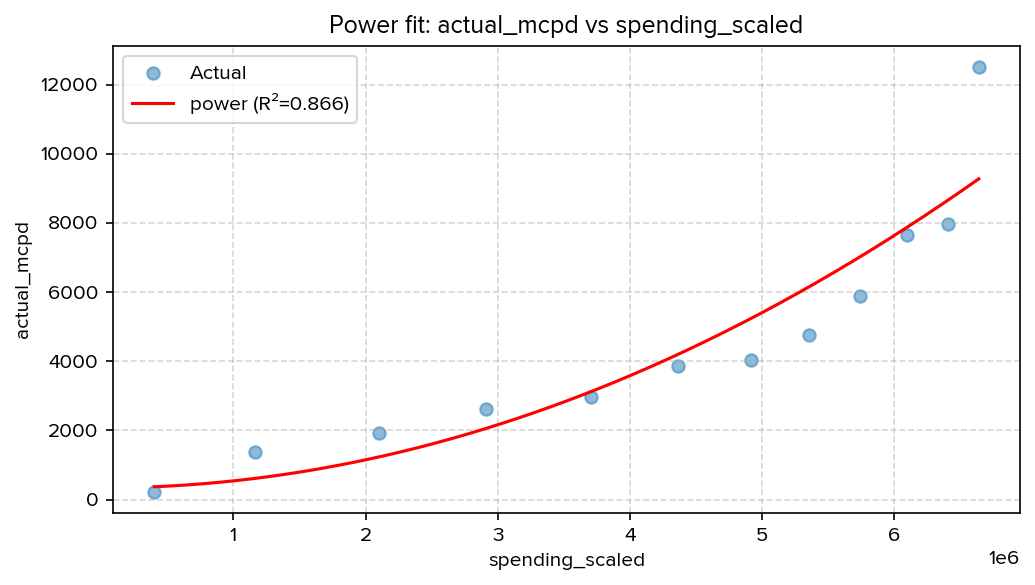


Fitted Models:
power     : actual_mcpd = 0.0000000002·(spending_scaled^2.0) + 339.3188470239   (R²=0.8657)

Best Model → power  (R²=0.8657)


In [41]:

# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
   df_global_weighted[df_global_weighted['spending_scaled'] <= 7000000],
    x_col="spending_scaled",
    y_col="actual_mcpd",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)


In [556]:
df_spending_mcpd = best_fit_df.copy()
df_spending_mcpd.head()

,spending_scaled,_pow_x,actual_mcpd
0,402160.293571,1.617329e+11,318.415893
1,414656.972667,1.719404e+11,320.559657
2,427153.651763,1.824602e+11,322.769016
3,439650.330859,1.932924e+11,325.043972
4,452147.009955,2.044369e+11,327.384523


#### mCPD <> CPIH

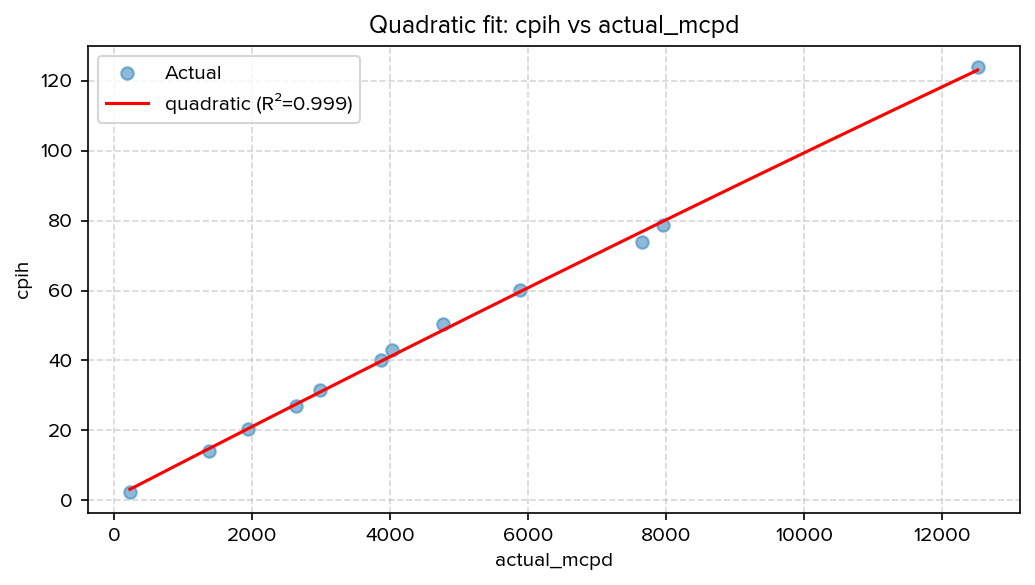


Fitted Models:
quadratic : cpih = -0.0000000356·actual_mcpd² + 0.010·actual_mcpd + 0.7881190721   (R²=0.9985)

Best Model → quadratic  (R²=0.9985)


In [42]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [43]:
df_mpcd_cpih = best_fit_df.copy()
df_mpcd_cpih.head()

,actual_mcpd,_x2,cpih
0,225.811351,50990.766057,3.093925
1,250.437907,62719.145290,3.345172
2,275.064464,75660.459089,3.596376
3,299.691020,89814.707453,3.847537
4,324.317576,105181.890384,4.098655


#### mCPD <> mCPIH

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


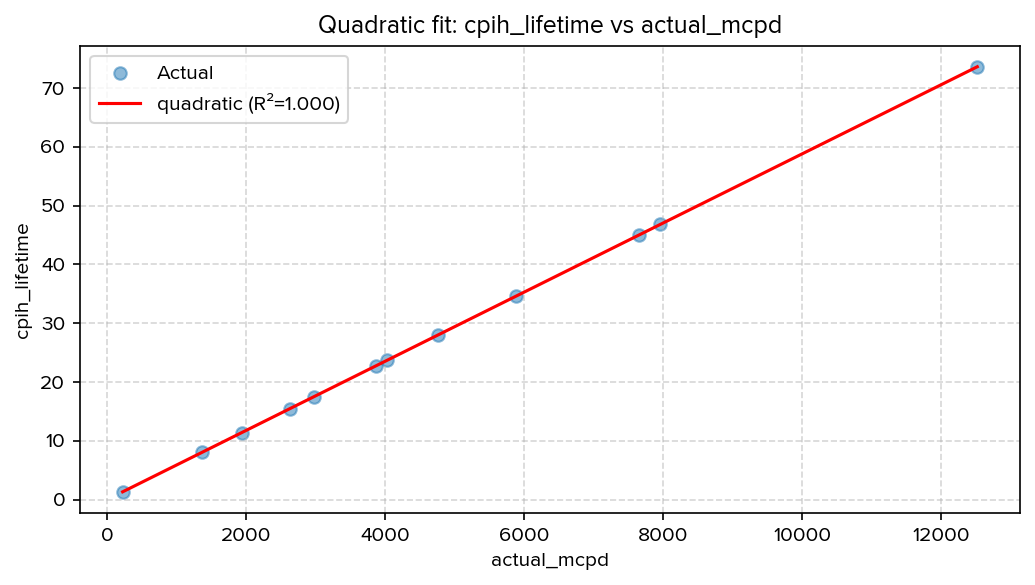


Fitted Models:
quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + -0.0000000000   (R²=1.0000)

Best Model → quadratic  (R²=1.0000)


In [44]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

best_kind, best_formula, best_r2, results_df, best_fit_df = fit_all_curves(
    df_global_weighted,
    x_col="actual_mcpd",
    y_col="cpih_lifetime",
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model


In [45]:
df_mpcd_cpih_lifetime = best_fit_df.copy()
df_mpcd_cpih_lifetime.head()

,actual_mcpd,_x2,cpih_lifetime
0,225.811351,50990.766057,1.328302
1,250.437907,62719.145290,1.473164
2,275.064464,75660.459089,1.618026
3,299.691020,89814.707453,1.762888
4,324.317576,105181.890384,1.907750


#### Plot the chart

In [46]:
# Step 1: spending range (10k to 150k in steps of 10k)
spending = np.arange(1000000, 6800001, 200000)

# Step 2: MCPD formula (replace coefficients with yours)
def mcpd_formula(s):
    """
Fitted Models:
quadratic : actual_mcpd = 0.0000000000·spending_scaled² + 0.001·spending_scaled + 19.3573791791   (R²=0.9924)
Fitted Models:
power     : actual_mcpd = 0.0000000002·(spending_scaled^2.0) + 284.4490050542   (R²=0.8687)
    """

    # return (0.00000000001*(s**2) + 0.001*s +  19.3573791791)
    return (0.0000000002*(s**2) + 284.4490050542)

# Step 3: CPIH formula in terms of MCPD
def cpih_formula(m):
    """
    Fitted Models:
    quadratic : cpih = 0.0000000015·actual_mcpd² + 0.010·actual_mcpd + -0.3101666886   (R²=0.9996)
    
    
Fitted Models:
quadratic : cpih = -0.0000000692·actual_mcpd² + 0.011·actual_mcpd + -0.5039911843   (R²=0.9987)
    """

    return ( -0.0000000692*m**2 + 0.011*m + -0.5039911843)

def cpih_lifetime_formula(m):
    """
    Fitted Models:
    quadratic : cpih_lifetime = -0.0000000000·actual_mcpd² + 0.006·actual_mcpd + 0.0000000001   (R²=1.0000)
    """
    return (-0.00000000001*m**2 + 0.006*m + -0.0000000001 )


# Step 4: Compute values
mcpd = mcpd_formula(spending)
cpih = cpih_formula(mcpd)
cpih_lifetime = cpih_lifetime_formula(mcpd)

# Step 5: Build dataframe
df_new = pd.DataFrame({
    "spending": spending,
    "mcpd": mcpd,
    "cpih": cpih,
    "cpih_lifetime": cpih_lifetime
})

df_new


,spending,mcpd,cpih,cpih_lifetime
0,1000000,484.449005,4.808707,2.906692
1,1200000,572.449005,5.770271,3.434691
2,1400000,676.449005,6.905283,4.058689
3,1600000,796.449005,8.213052,4.778688
4,1800000,932.449005,9.692781,5.594685
5,2000000,1084.449005,11.343567,6.506682
6,2200000,1252.449005,13.164399,7.514678
7,2400000,1436.449005,15.154162,8.618673
8,2600000,1636.449005,17.311633,9.818667
9,2800000,1852.449005,19.635483,11.114660


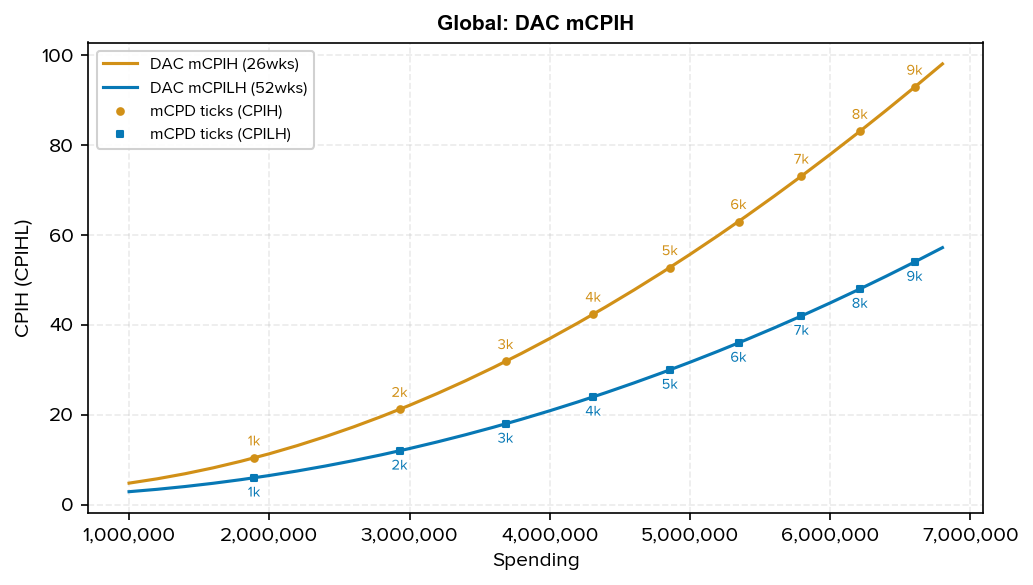

In [52]:
mcpd_levels = np.arange(1000, 10000, 1000)  # 1k..9k (adjust as needed)

# a, b, c = 0.00000000001, 0.001, 19.3573791791 
# # quadratic : actual_mcpd = 0.0000000000·spending_scaled² + 0.001·spending_scaled + 19.3573791791   (R²=0.9924)
# def spend_from_mcpd(m):
#     D = b**2 - 4*a*(c - m)
#     return (-b + np.sqrt(D)) / (2*a)

a = 0.0000000002
c = 284.4490050542 

# power     : actual_mcpd = 0.0000000002·(spending_scaled^2.0) + 284.4490050542   (R²=0.8687)

def spend_from_mcpd(m):
    m = np.asarray(m)  # ensure NumPy array
    # if np.any(m <= c):
        # raise ValueError(f"Some MCPD values are <= {c}, spending would be undefined.")
    return np.sqrt((m - c) / a)

# Exact spending values that produce those MCPD levels
spending_marks = spend_from_mcpd(mcpd_levels)
cpih_marks = cpih_formula(mcpd_levels)
cpih_lifetime_marks = cpih_lifetime_formula(mcpd_levels)

plt.rcParams.update({
    "figure.dpi": 150,                   # crisp display at normal size
    "savefig.dpi": 300,                  # high-res export
    "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,              
})

colors = {"cpih": "#d19017", "cpih_lifetime": "#0778b5", "dxo": "#038c0a", "dxo_cpih_15": "#403f3e"}

fig, ax = plt.subplots(figsize=(7, 4))   # regular size

line1, = ax.plot(df_new["spending"], df_new["cpih"], label="DAC mCPIH (26wks)", color=colors["cpih"], linewidth=1.5, zorder=2)
line2, = ax.plot(df_new["spending"], df_new["cpih_lifetime"], label="DAC mCPILH (52wks)", color=colors["cpih_lifetime"], linewidth=1.5, zorder=2)
# line3, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih"], label="DxO CPIH", color=colors["dxo"], linestyle="--", linewidth=1.5, zorder=1)
# line4, = ax.plot(df_global_dxo["spending"], df_global_dxo["dxo_cpih_15"], label="DxO CPIH ($15)", color=colors["dxo_cpih_15"], linestyle="--", linewidth=1.5, zorder=1)
# 5) Tick markers (smaller, same color as lines)
ax.scatter(spending_marks, cpih_marks, marker='o', s=10, color=colors["cpih"], zorder=3)
ax.scatter(spending_marks, cpih_lifetime_marks, marker='s', s=10, color=colors["cpih_lifetime"], zorder=3)

# 6) Annotations (CPIH above, Lifetime below) with subtle halo for readability
halo = [pe.withStroke(linewidth=2, foreground="white")]
for s, y, lvl in zip(spending_marks, cpih_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih"], path_effects=halo)

for s, y, lvl in zip(spending_marks, cpih_lifetime_marks, mcpd_levels):
    ax.annotate(f"{int(lvl/1000)}k", (s, y), xytext=(0, -9), textcoords="offset points", ha="center", fontsize=7, color=colors["cpih_lifetime"], path_effects=halo)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.set_xlabel("Spending")
ax.set_ylabel("CPIH (CPIHL)")
# ax.set_title("Global: DAC vs DxO CPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.set_title("Global: DAC mCPIH", fontfamily="Arial", fontweight="bold", fontsize = 10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas on x

mcpd_handle1 = ax.scatter([], [], marker='o', s=10, color=colors["cpih"], label="mCPD ticks (CPIH)")
mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
# mcpd_handle2 = ax.scatter([], [], marker='s', s=10, color=colors["cpih_lifetime"], label="mCPD ticks (CPILH)")
# ax.legend(handles=[line1, line2, line3, line4, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")
ax.legend(handles=[line1, line2, mcpd_handle1, mcpd_handle2], fontsize=8, framealpha=0.9, loc="upper left")

fig.tight_layout()
plt.show()

In [563]:
merged_df = df_sm81_cohort_weighted.merge(
    df_sm0[['mcpd_scenario', 'spending']],  # include submarket_id explicitly
    on='mcpd_scenario',
    how='left',
    suffixes=('', '_sm0')
)


In [564]:
merged_df['spending_ratio'] = merged_df['spending'] / merged_df['spending_sm0']
merged_df

,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd,spending_sm0,spending_ratio
0,1000,6783.492261,148.034044,32.643630,230.224027,2543.400203,6783.492261,148.034044,32.643630,230.224027,2543.400203,5549.417075,2.222580,1.222379,29.464745,207.804472,4.669642e+05,0.014527
1,2000,17479.736071,193.274233,41.621860,293.934485,3272.464452,10696.243810,45.240189,8.978230,63.710458,729.064249,1526.299102,12.225996,7.007960,167.888351,1191.353284,1.328705e+06,0.013155
2,3000,31842.197174,228.486371,49.517165,349.703302,3903.412640,14362.461103,35.212138,7.895305,55.768817,630.948188,1342.201836,18.969414,10.700672,257.535696,1819.114176,2.254686e+06,0.014123
3,4000,43418.565877,251.680076,54.294138,383.747948,4284.876734,11576.368703,23.193705,4.776973,34.044646,381.464094,812.085467,25.289337,14.255111,340.034925,2423.368917,3.036463e+06,0.014299
4,5000,53994.436667,267.361024,57.654040,407.673770,4556.763889,10575.870790,15.680948,3.359902,23.925821,271.887155,571.183368,32.415013,18.515719,442.027493,3147.672244,3.797443e+06,0.014219
5,6000,63085.153840,277.497588,59.938898,423.715574,4731.360202,9090.717173,10.136564,2.284858,16.041804,174.596313,388.425883,43.389219,23.403994,566.689202,3978.679036,4.425450e+06,0.014255
6,7000,70792.371383,285.641159,61.742416,436.335571,4867.946329,7707.217543,8.143571,1.803518,12.619997,136.586127,306.597990,47.022940,25.137861,610.714690,4273.436308,4.965759e+06,0.014256
7,8000,77078.732807,294.108789,63.179724,446.385304,4978.519289,6286.361424,8.467629,1.437308,10.049734,110.572959,244.342318,47.377176,25.727682,625.525175,4373.705924,5.418885e+06,0.014224
8,9000,82221.095455,298.858557,64.055179,452.519346,5047.281226,5142.362648,4.749768,0.875455,6.134042,68.761938,148.827320,62.320847,34.552545,838.331827,5873.932638,5.807385e+06,0.014158
9,10000,85834.584969,302.240901,64.567000,456.194202,5090.920109,3613.489514,3.382344,0.511821,3.674856,43.638882,87.009651,69.003629,41.529755,983.301018,7060.058431,6.118613e+06,0.014028


In [565]:
df_sm0_calc

,submarket_id,mcpd_scenario,spending,applicants,new_dx,wad,hours,inc_spend,inc_applicants,inc_new_dx,inc_wad,inc_hours,inc_hours_lifetime,cpih,cpih_lifetime,cpiwad,actual_mcpd
0,0,1000,4.669642e+05,8169.743731,1703.735784,11969.157528,136629.136869,466964.214273,8169.743731,1703.735784,11969.157528,136629.136869,289635.083227,2.848125,1.612250,39.013958,274.082530
1,0,2000,1.328705e+06,11808.890138,2405.857428,16920.316741,190258.651040,861740.667110,3639.146407,702.121644,4951.159213,53629.514172,119360.679489,13.390336,7.219636,174.048264,1227.338132
2,0,3000,2.254686e+06,13956.571084,2823.832750,19876.235518,222269.328212,925980.824683,2147.680946,417.975322,2955.918777,32010.677171,71055.804786,24.106041,13.031741,313.263285,2215.395923
3,0,4000,3.036463e+06,15298.070031,3073.467708,21655.563289,240817.524367,781777.335867,1341.498947,249.634958,1779.327771,18548.196155,42437.942788,35.123691,18.421660,439.366680,3131.682131
4,0,5000,3.797443e+06,16405.958823,3275.364326,23090.265497,256056.970641,760979.724742,1107.888791,201.896618,1434.702208,15239.446274,34322.425104,41.612389,22.171502,530.409531,3769.155379
5,0,6000,4.425450e+06,17112.736606,3408.040026,24029.971439,266072.319642,628007.121212,706.777783,132.675700,939.705942,10015.349001,22554.868981,52.253723,27.843528,668.301745,4733.399724
6,0,7000,4.965759e+06,17630.457314,3512.724291,24775.138123,273588.690991,540308.945270,517.720708,104.684265,745.166684,7516.371349,17796.325069,59.903567,30.360703,725.084678,5161.319561
7,0,8000,5.418885e+06,18106.955830,3602.525084,25415.959887,280102.242471,453125.915792,476.498516,89.800793,640.821763,6513.551480,15266.134884,57.972203,29.681771,707.101322,5045.901027
8,0,9000,5.807385e+06,18527.999344,3684.558073,26004.698445,285788.006830,388500.293233,421.043514,82.032989,588.738559,5685.764359,13945.608058,56.940496,27.858254,659.885933,4735.903201
9,0,10000,6.118613e+06,18914.321342,3753.626956,26504.556407,290120.197965,311227.886167,386.321999,69.068883,499.857962,4332.191136,11741.710076,59.867297,26.506180,622.632647,4506.050678


In [566]:
df_sm81 = all_sms_daco_output[all_sms_daco_output['submarket_id'] == 81]
# drop two outlier points:
df_sm81 = df_sm81[df_sm81['mcpd_scenario'] <= 10000]

df_sm81 = df_sm81.groupby(['submarket_id','mcpd_scenario']).agg({
    'spending': 'mean',
    'applicants': 'mean',
    'new_dx': 'mean',
    'wad': 'mean',
    'hours': 'mean',
    'cpih': 'mean',
    'cpiwad': 'mean',
    'cpid': 'mean',
    'cp_wad': 'mean',
    'cp_hour': 'mean',
    'hours_per_dx': 'mean',
    'inc_spend': 'mean',
    'inc_apps': 'mean',
    'inc_new_dx': 'mean',
    'inc_wad': 'mean',
    'inc_hours': 'mean',
    'inc_spend_final': 'mean',
    'inc_apps_final': 'mean',
    'inc_new_dx_final': 'mean',
    'inc_wad_final': 'mean',
    'inc_hours_final': 'mean',
    'inc_hours_lifetime': 'mean',
    'cpih_lifetime': 'mean',
}).reset_index()

df_sm81

KeyError: "Column(s) ['cp_hour', 'cp_wad', 'cpid', 'cpih', 'cpih_lifetime', 'cpiwad', 'hours_per_dx', 'inc_apps', 'inc_apps_final', 'inc_hours', 'inc_hours_final', 'inc_hours_lifetime', 'inc_new_dx', 'inc_new_dx_final', 'inc_spend', 'inc_spend_final', 'inc_wad', 'inc_wad_final'] do not exist"

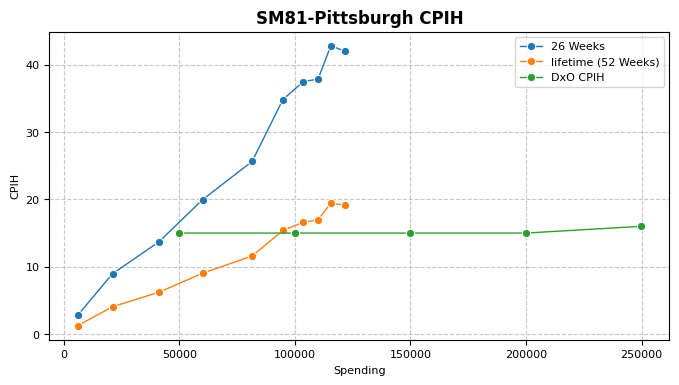

In [ ]:

plt.figure(figsize=(8, 4))
# mcpd_scenario
sns.lineplot(data=df_sm81, x='spending', y='cpih', marker='o', label='26 Weeks', linewidth=1)
sns.lineplot(data=df_sm81, x='spending', y='cpih_lifetime', marker='o', label= 'lifetime (52 Weeks)', linewidth=1)
sns.lineplot(data=df_dxo, x='spending', y='dxo_cpih', marker='o', label='DxO CPIH', linewidth=1)
# Customize the plot
plt.title(f'SM81-Pittsburgh CPIH', fontsize=12, fontweight='bold')
plt.xlabel('Spending', fontsize=8)
plt.ylabel('CPIH', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
# Show the plot
plt.show()

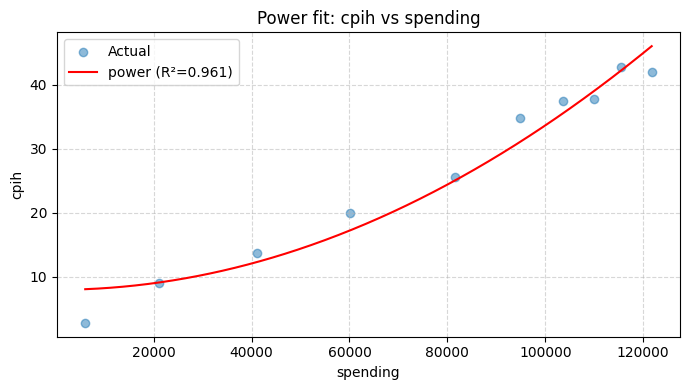


Fitted Models:
power     : cpih = 0.000·(spending^2.0) + 7.961   (R²=0.9613)

Best Model → power  (R²=0.9613)
[run_regression] Auto-selected scale=1.787e-05 for sat_exp


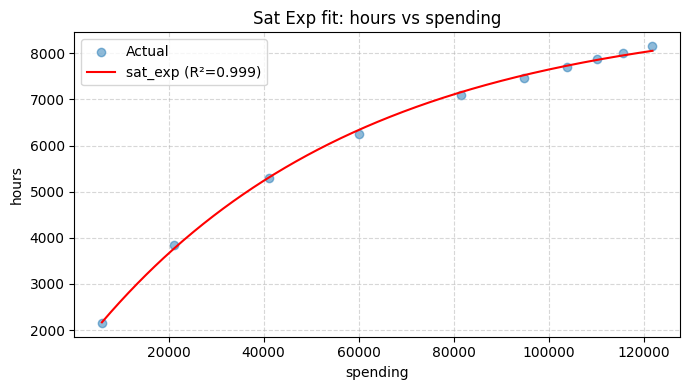


Fitted Models:
sat_exp   : hours = 7500.174·(1 − exp(−1.79e-05·spending)) + 1404.760   (R²=0.9990)

Best Model → sat_exp  (R²=0.9990)


In [ ]:
# good but unreachable curve: paid_media_spend vs paid_media_applicants
SHAPES = ["power"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81,
    x_col="spending",
    y_col="cpih",
    # y_col_lifetime="cpih_lifetime",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

SHAPES = ["sat_exp"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81,
    x_col="spending",
    y_col="hours",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

In [ ]:
df_sm81_cohort[(df_sm81_cohort['submarket_id'] == 34) & (df_sm81_cohort['spend_date'] == '2025-10-27')]

,spend_date,submarket_id,spending,applicants,new_dx,wad,hours,cpa,cpd,cp_wad,...,inc_hours_final,cpih,cpih_adj,hours_per_dx,cpiwad,cpid,lifetime_hours,inc_hours_lifetime,cpih_lifetime,total_deliveries
0,2025-10-27,34,13002.61554,246.761830,59.462247,397.408397,4434.127864,52.692978,218.670099,32.718522,...,4434.127864,2.932395,2.932395,11.157610,32.718522,218.670099,1.718459e+06,10108.582059,1.286295,353174
1,2025-10-27,34,25102.61554,313.264696,76.642828,512.298151,5716.028782,80.132284,327.527263,49.000012,...,1281.900918,9.439107,9.439107,11.157661,105.318356,704.283552,2.214978e+06,2920.698624,4.142844,353174
2,2025-10-27,34,40502.61554,356.897208,87.533422,584.941854,6526.590181,113.485381,462.710295,69.242123,...,810.561400,18.999178,18.999178,11.158041,211.993600,1414.064210,2.529716e+06,1851.401076,8.318025,353174
3,2025-10-27,34,59002.61554,393.255070,96.661537,645.836532,7206.055928,150.036503,610.404276,91.358436,...,679.465746,27.227274,27.227274,11.158048,303.803231,2026.705401,2.793518e+06,1551.779553,11.921796,353174
4,2025-10-27,34,77987.16954,445.457932,106.350270,710.519866,7927.802047,175.071907,733.304856,109.760716,...,721.746120,26.303645,26.303645,11.158147,293.499930,1959.446502,3.073523e+06,1647.084611,11.526156,353174
5,2025-10-27,34,97487.16954,470.805248,112.474469,751.299258,8382.833482,207.064747,866.749322,129.758107,...,455.031435,42.854182,42.854182,11.158367,478.182701,3184.090084,3.250512e+06,1041.113760,18.729942,353174
6,2025-10-27,34,118950.71654,493.712954,118.067786,788.556587,8798.562971,240.930921,1007.478166,150.846139,...,415.729489,51.628637,51.628637,11.158328,576.089270,3837.355495,3.412159e+06,950.863946,22.572679,353174
7,2025-10-27,34,131441.62086,512.090595,121.666117,812.357644,9064.163613,256.676499,1080.346966,161.802652,...,265.600641,47.028894,47.028894,11.159195,524.804601,3471.304566,3.516151e+06,611.716343,20.419439,353174
8,2025-10-27,34,141541.62086,528.692480,124.650309,832.038496,9283.792941,267.720132,1135.509591,170.114269,...,219.629328,45.986572,45.986572,11.159544,513.189157,3384.501779,3.602394e+06,507.312483,19.908834,353174
9,2025-10-27,34,147605.40171,537.669646,126.302715,842.919017,9405.217467,274.528054,1168.663727,175.112198,...,121.424526,49.938682,49.938682,11.159808,557.306091,3669.666554,3.650148e+06,280.909104,21.586274,353174


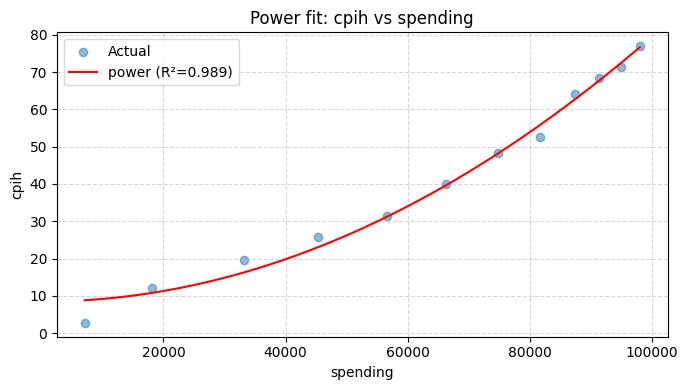


Fitted Models:
power     : cpih = 0.000·(spending^2.0) + 8.436   (R²=0.9895)

Best Model → power  (R²=0.9895)
[run_regression] Auto-selected scale=2.228e-05 for sat_exp


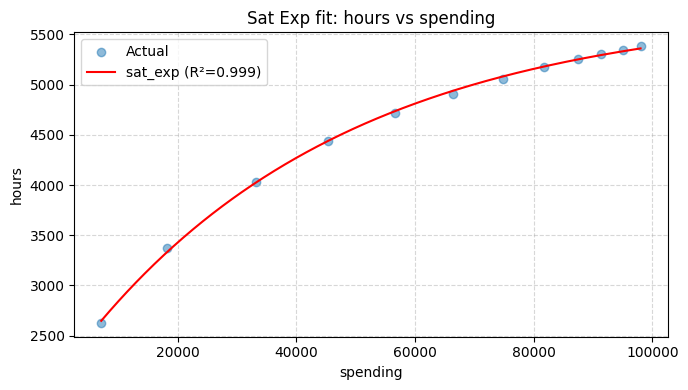


Fitted Models:
sat_exp   : hours = 3662.949·(1 − exp(−2.23e-05·spending)) + 2110.694   (R²=0.9994)

Best Model → sat_exp  (R²=0.9994)


In [ ]:
# good but unreachable curve: paid_media_spend vs paid_media_applicants
SHAPES = ["power"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="spending",
    y_col="cpih",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)

SHAPES = ["sat_exp"]
best_kind, best_formula, best_r2 = fit_all_curves(
    df_sm81_cohort_weighted,
    x_col="spending",
    y_col="hours",
    # optional per-shape tweaks
    sat_exp=dict(scale=None),          # let auto-tune
    hill=dict(h=2, k=1000),
)